# Surrogate Construction for Genz Functions: BCS

This notebook constructs a PC surrogate for Genz functions and gives the normalized root mean square error between the surrogate and the actual function. Both the Genz function and PCE are defined on [-1,1].

In [1]:
import numpy as np
import math  
from scipy.stats import qmc
import pandas as pd

import PyUQTk.pce as uqtkpce
import PyUQTk.PyPCE.pce_tools as pce_tools
from PyUQTk.utils.func import *

PyMC is required for some of the MCMC postprocessing codes.
Will proceed without, but some convergence tests will not be available.


We define our input parameters. BCS is best for undetermined models and/or large basis sets.

In [2]:
# PC parameters
nord = 4            # Order of the final PCE basis
ndim = 4            # Number of dimensions
pc_type = "LU"      # Polynomial type
pc_alpha = 0.0      # Free parameter > -1 for Gamma-Laguerre and Beta-Jacobi PCs
pc_beta = 1.0       # Free parameter > -1 for Gamma-Laguerre and Beta-Jacobi PCs

# Model to represent
model = 'genz_osc'   # Choices are 'genz_osc', 'genz_exp', 'genz_cont','genz_gaus','genz_cpeak', 'genz_ppeak'

We randomly generate training and testing data.

In [3]:
# PC model with a full basis set
pc_model =  uqtkpce.PCSet("NISPnoq", nord, ndim, pc_type, pc_alpha, pc_beta)

# Random number generator
rng = qmc.LatinHypercube(d=ndim, seed=43)

#Training
np.random.seed(42)
nTrain = int(pc_model.GetNumberPCTerms()*1) # Number of training samples
x_tr_no_noise = 2*rng.random(n=nTrain)-1
x_train = x_tr_no_noise + np.random.normal(0, 0.1, size = x_tr_no_noise.shape)
y_train = func(x_tr_no_noise, model, np.ones(ndim+1))

#Testing
nTest = 10000  # Number of testing samples
x_test_no_noise = 2*rng.random(n=nTest)-1
x_test = x_test_no_noise + np.random.normal(0, 0.1, size = x_test_no_noise.shape)
y_test = func(x_test_no_noise, model, np.ones(ndim+1))

## BCS with default settings

We then perform BCS by inputting the PCSet object that contains the starting basis, the x training data, and the y training data. Set verbose to 0 to silence print statements, to 1 for some statements, and 2 for all statements.

We then evaluate the polynomial chaos expansion and calculate the normalized root mean square error.

In [4]:
# Define PC object
pc_start = uqtkpce.PCSet("NISPnoq", nord, ndim, pc_type, pc_alpha, pc_beta)

# Perform BCS
pc_final, c_k = pce_tools.UQTkBCS(pc_start, x_train, y_train, verbose=1)

# Evaluate the PCE
pce_evals = pce_tools.UQTkEvaluatePCE(pc_final, c_k, x_test)

# Calculate error metric
MSE = np.square(np.subtract(y_test, pce_evals)).mean()
NRMSE=math.sqrt(MSE)/np.abs(y_test.mean())
print("The NRMS error between a", ndim, "-dimensional", model, "function and a BCS-based PC surrogate of \
order", nord, "is")
NRMSE

============  Split # 1 / 1 ============
==== BCS with multiindex of size 70 ====
BCS has selected 17 basis terms out of 70
Coefficients:
[-0.40426661 -0.39440045 -0.38787995 -0.38299555 -0.36322194  0.20481367
  0.17744271  0.17615609  0.16997361  0.16081588  0.101805    0.10113724
  0.09661748 -0.07820574 -0.06027544  0.05970374  0.03663573]
17  terms retained out of a full basis of size 70
The NRMS error between a 4 -dimensional genz_osc function and a BCS-based PC surrogate of order 4 is


0.3985792514972794

## Basis cross-validation
 to ensure important basis terms are selected, we may also perform BCS multiple times on multiple splits of the training data. BCS selects basis terms in each split, then the intersection of the basis terms is found, and regression is run on that set of intersecting basis terms. The default setting is ntry=1. Here, we show ntry=2.

In [5]:
# Define PC object
pc_start = uqtkpce.PCSet("NISPnoq", nord, ndim, pc_type, pc_alpha, pc_beta)

# Perform BCS
pc_final, c_k = pce_tools.UQTkBCS(pc_start, x_train, y_train, ntry=2, verbose=1)

# Evaluate the PCE
pce_evals = pce_tools.UQTkEvaluatePCE(pc_final, c_k, x_test)

# Calculate error metric
MSE = np.square(np.subtract(y_test, pce_evals)).mean()
NRMSE=math.sqrt(MSE)/np.abs(y_test.mean())
print("The NRMS error between a", ndim, "-dimensional", model, "function and a BCS-based PC surrogate of \
order", nord, "is")
NRMSE

============  Split # 1 / 2 ============
==== BCS with multiindex of size 70 ====
BCS has selected 7 basis terms out of 70
============  Split # 2 / 2 ============
==== BCS with multiindex of size 70 ====
BCS has selected 11 basis terms out of 70
Coefficients:
[-0.36159581 -0.4003449  -0.42695139 -0.36334667 -0.42364005]
5  terms retained out of a full basis of size 70
The NRMS error between a 4 -dimensional genz_osc function and a BCS-based PC surrogate of order 4 is


0.3662391313936097

## Basis growth
We may also perform BCS with iterations of basis growth. We give BCS a basis of a smaller starting order, then grow the basis in the areas that are most advantageous. The default is mindex_growth = None and the niter (number of iterations) = 1.

Here we show 3 iterations of nonconservative basis growth, which adds multiindex entries of a higher order if any of the parents are in the current set.  

In [6]:
niter=2

# Define PC object
start_ord = nord-niter+1 # if basis growth, shrink starting basis to allow for growth niter-1 times  
pc_start = uqtkpce.PCSet("NISPnoq", start_ord, ndim, pc_type, pc_alpha, pc_beta)

# Perform BCS
pc_final, c_k = pce_tools.UQTkBCS(pc_start, x_train, y_train, niter=niter, mindex_growth='nonconservative', verbose=1)

# Evaluate the PCE
pce_evals = pce_tools.UQTkEvaluatePCE(pc_final, c_k, x_test)

# Calculate error metric
MSE = np.square(np.subtract(y_test, pce_evals)).mean()
NRMSE=math.sqrt(MSE)/np.abs(y_test.mean())
print("The NRMS error between a", ndim, "-dimensional", model, "function and a BCS-based PC surrogate of \
order", nord, "is")
NRMSE

============  Split # 1 / 1 ============
==== BCS with multiindex of size 35 ====
BCS has selected 14 basis terms out of 35
==== BCS with multiindex of size 49 ====
BCS has selected 18 basis terms out of 49
Coefficients:
[-0.40243839 -0.39576055 -0.39063821 -0.38718265 -0.36294641  0.19040466
  0.17425612  0.16684948  0.16062087  0.1352436  -0.12675721  0.11797902
 -0.09788142  0.09333043  0.09002183  0.06397633 -0.04775366  0.03896472]
18  terms retained out of a full basis of size 70
The NRMS error between a 4 -dimensional genz_osc function and a BCS-based PC surrogate of order 4 is


0.3888750297379594

We can also use conservative basis growth, which adds multiindex entries of a higher order if all parents are in the current set.

In [7]:
# Perform BCS
pc_final, c_k = pce_tools.UQTkBCS(pc_start, x_train, y_train, niter=niter, mindex_growth='conservative', verbose=1)

# Evaluate the PCE
pce_evals = pce_tools.UQTkEvaluatePCE(pc_final, c_k, x_test)

# Calculate error metric
MSE = np.square(np.subtract(y_test, pce_evals)).mean()
NRMSE=math.sqrt(MSE)/np.abs(y_test.mean())
print("The NRMS error between a", ndim, "-dimensional", model, "function and a BCS-based PC surrogate of \
order", nord, "is")
NRMSE

============  Split # 1 / 1 ============
==== BCS with multiindex of size 35 ====
BCS has selected 14 basis terms out of 35
==== BCS with multiindex of size 23 ====
BCS has selected 14 basis terms out of 23
Coefficients:
[-0.40685524 -0.39667432 -0.39222092 -0.37117262 -0.35285434  0.21442471
  0.16239871  0.15118613  0.14291924  0.08766108  0.07300681  0.06764256
  0.06712614 -0.05355022]
14  terms retained out of a full basis of size 70
The NRMS error between a 4 -dimensional genz_osc function and a BCS-based PC surrogate of order 4 is


0.37209580489576466

## Eta optimization

BCS uses the stopping threshold eta to determine how many coefficients to retain in the final basis. Larger etas stop the algorithm sooner, causing BCS to retain fewer terms. The default eta is 1e-3. 

If eta is given an array or list as an argument, the optimum value is chosen through cross-validation on a specified number of folds (eta_folds). If eta_plot = True, a plot of the cross-validation results is generated.

This example performs it with no growth and then 1-3 iterations of nonconservative basis growth.

The optimal eta is selected according to the following process:
- Split training into folds (according to eta_folds)
- For each fold:
    -  For each eta in the list, 
        - Perform BCS
        - Compute RMSE for training and testing
- Average the training and testing errors over the folds
- Return the eta with the lowest average RMSE

The NRMS error between a 4 -dimensional genz_osc function and a BCS-based PC surrogate of order 4 is


0.3524436425793535

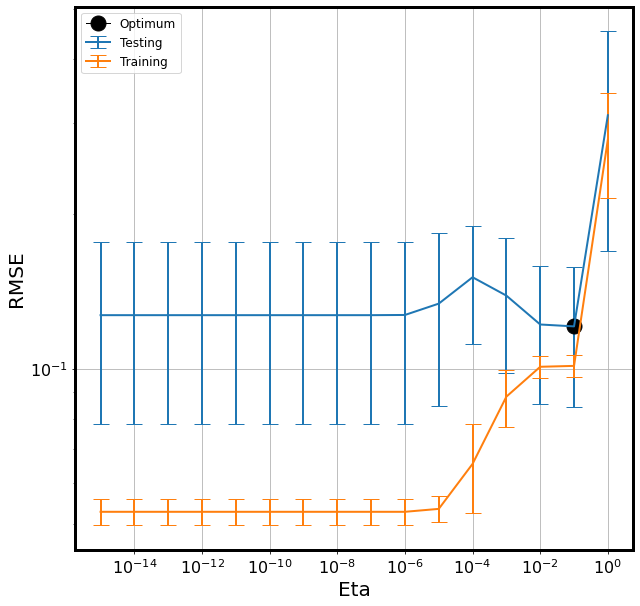

In [8]:
# create an array of possible etas: [1e-16, 1e-15, ... , 1e-2, 1e-1, 1]
eta = 1/np.power(10,[i for i in range(0,16)])

# Perform BCS
pc_final, c_k = pce_tools.UQTkBCS(pc_start, x_train, y_train, niter=2, mindex_growth='nonconservative', eta=eta, eta_folds=10, eta_plot=True)

# Evaluate the PCE
pce_evals = pce_tools.UQTkEvaluatePCE(pc_final, c_k, x_test)

# Calculate error metric
MSE = np.square(np.subtract(y_test, pce_evals)).mean()
NRMSE=math.sqrt(MSE)/np.abs(y_test.mean())
print("The NRMS error between a", ndim, "-dimensional", model, "function and a BCS-based PC surrogate of \
order", nord, "is")
NRMSE

We can also use more folds for eta cross-validation. This decreases the bias but increases variance and computational cost.

The NRMS error between a 4 -dimensional genz_osc function and a BCS-based PC surrogate of order 4 is


0.4552579390926737

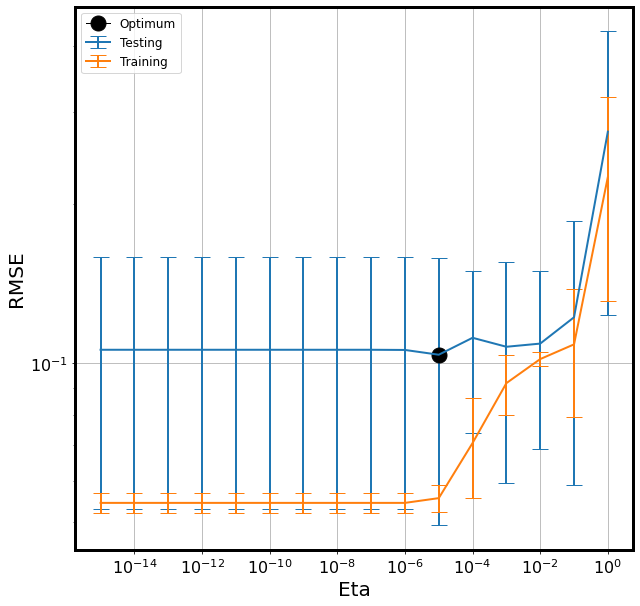

In [9]:
# Perform BCS
pc_final, c_k = pce_tools.UQTkBCS(pc_start, x_train, y_train, niter=2, mindex_growth='nonconservative', eta=eta, eta_folds=20, eta_plot=True)

# Evaluate the PCE
pce_evals = pce_tools.UQTkEvaluatePCE(pc_final, c_k, x_test)

# Calculate error metric
MSE = np.square(np.subtract(y_test, pce_evals)).mean()
NRMSE=math.sqrt(MSE)/np.abs(y_test.mean())
print("The NRMS error between a", ndim, "-dimensional", model, "function and a BCS-based PC surrogate of \
order", nord, "is")
NRMSE

If BCS is set to grow the basis, eta cross-validation does not implement basis growth by default. However, if eta_growth = True, the selection for optimum eta will take basis growth into account. This increases both computational time and precision.

The NRMS error between a 4 -dimensional genz_osc function and a BCS-based PC surrogate of order 4 is


0.3524436425793535

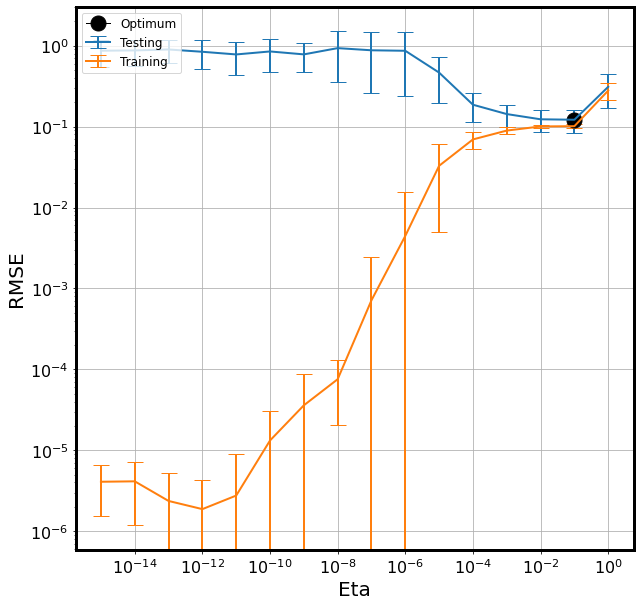

In [10]:
# Perform BCS
pc_final, c_k = pce_tools.UQTkBCS(pc_start, x_train, y_train, niter=3, mindex_growth='nonconservative', eta=eta, eta_folds=10, eta_growth=True, eta_plot=True)

# Evaluate the PCE
pce_evals = pce_tools.UQTkEvaluatePCE(pc_final, c_k, x_test)

# Calculate error metric
MSE = np.square(np.subtract(y_test, pce_evals)).mean()
NRMSE=math.sqrt(MSE)/np.abs(y_test.mean())
print("The NRMS error between a", ndim, "-dimensional", model, "function and a BCS-based PC surrogate of \
order", nord, "is")
NRMSE

# Start HERE

## regparams, sigma, trval_frac, npccut, pcf_thr, verbose)
Regularization weights (provide an array or value); if None, they are autopopulated
default is None

To set a fixed scalar, provide a fixed nonnegative value. (this then becomes a =n array of that scalar)
To autopopulate a scalar, set regparams = 0.
To set a fixed vector of weights, provide an array [#PC terms,].
To autopopulate a vector, set reg_params = None, which is the suggested method. (gives np.array([]) to bcs)

## Noise
Inital noise variance we assume is in the data
Initial noise variance; updated in BCS
default is 1e-8

## Basis term trimming
these are the default values
trval_frac = None                   # Fraction of total data to use in each split
npccut = None                       # Maximum number of PC coefficients to retain
pcf_thr = None                      # Minimum value (by magnitude) for PC coefficients

        trval_frac: Fraction of the total input data to use in each split;
                            if None (default), 1/ntry is used
        npccut:     Maximum number of PC terms to retain, for pruning 'by hand';
                            default is None
        pcf_thr:    Minimum value (magnitude) for PC coefficients, for pruning low PC coefficients 'by hand'
                            default is None

pc_final, c_k = pce_tools.UQTkBCS(pc_start, x_train, y_train, regparams=regparams)


pc_final, c_k = pce_tools.UQTkBCS(pc_start, x_train, y_train, sigma=sigma)



pc_final, c_k = pce_tools.UQTkBCS(pc_start, x_train, y_train, trval_frac, npccut, pcf_thr, verbose)

In [11]:
# BCS parameters
eta = 1/np.power(10,[i for i in range(0,16)])     # Threshold for stopping the algorithm
niter = 1                                        # Number of iterations to run, must be > 0
mindex_growth =  'nonconservative'               # Method for basis growth; options are "conservative," "nonconservative," or None
ntry = 3                                         # Number of splits for cross-validation of the retained basis terms 
eta_folds = 20                      # Number of folds to use for eta cross-validation                          
eta_growth =  False                 # Flag for using basis growth in eta optimization
eta_plot = True                     # Flag for plotting possible etas by RMSEs during optimization
regparams = None                    # Regularization weights (provide an array or value); if None, they are autopopulated
sigma = 1e-8                        # Initial noise variance; updated in BCS
trval_frac = None                   # Fraction of total data to use in each split
npccut = None                       # Maximum number of PC coefficients to retain
pcf_thr = None                      # Minimum value (by magnitude) for PC coefficients
verbose = 1                         # Flag for print statements: 0 for none, 1 for minimal statements, 2 for full output



We perform BCS. (UQTkBCS and UQTKOptimizeEta are located in PyUQTk/PyPCE/pce_tools.py)

This example performs it with no growth and then 1-3 iterations of nonconservative basis growth.

During the process, an optimal eta is selected through cross validation in the following process:
- Input the starting basis, training data, list of potential etas, number of cross-validation folds, the kind of basis growth to perform
- Split training into folds 
- For each fold:
    -  For each eta in the list, 
        - Perform BCS with basis growth (if specified)
        - Compute RMSE for training and testing
- Compute the average training and testing errors over the folds
- Return the eta with the lowest average RMSE

After an optimal eta is selected, BCS is performed on several (ntry) splits of the data. The intersection of the selected multiindices for each split is taken and used as the basis for regression, which determines the final coefficients.

#### No Growth:

Optimal eta is 0.01
============  Split # 1 / 3 ============
==== BCS with multiindex of size 70 ====
BCS has selected 7 basis terms out of 70
============  Split # 2 / 3 ============
==== BCS with multiindex of size 70 ====
BCS has selected 6 basis terms out of 70
============  Split # 3 / 3 ============
==== BCS with multiindex of size 70 ====
BCS has selected 10 basis terms out of 70
Coefficients:
[-0.35826453]
1  terms retained out of a full basis of size 70
The NRMS error between a 4 -dimensional genz_osc function and a BCS-based PC surrogate of order 4 is


1.3064594107201128

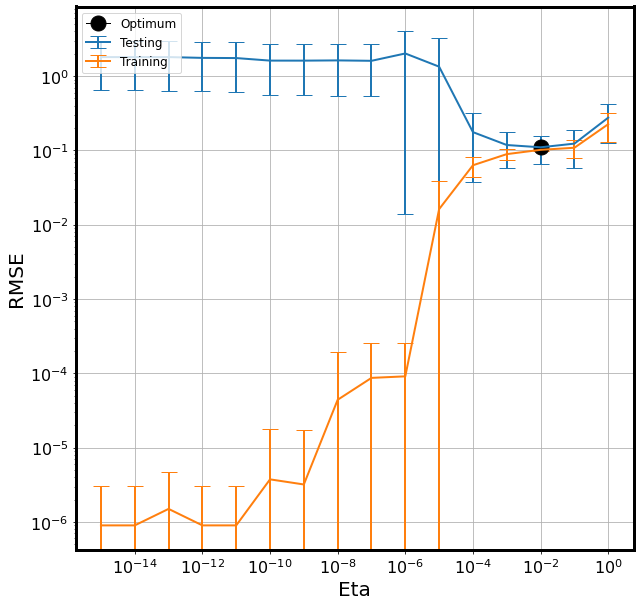

In [12]:
# Options for growth
niter = 1
mindex_growth = None

# Determine order of the starting basis
if mindex_growth == None:
    start_ord = nord # if no basis growth, order of the final basis = order of the starting basis
else:
    start_ord = nord-niter+1 # if basis growth, shrink starting basis to allow for growth niter-1 times
    
# Define PC object
pc_start = uqtkpce.PCSet("NISPnoq", start_ord, ndim, pc_type, pc_alpha, pc_beta)

# Determine coefficients through BCS
pc_final, c_k = pce_tools.UQTkBCS(pc_start, x_train, y_train, eta, niter, mindex_growth, ntry, eta_folds, eta_growth, eta_plot, regparams, sigma, trval_frac, npccut, pcf_thr, verbose)

# Evaluate the PCE
pce_evals = pce_tools.UQTkEvaluatePCE(pc_final, c_k, x_test)

# Calculate error metric
MSE = np.square(np.subtract(y_test, pce_evals)).mean()
NRMSE=math.sqrt(MSE)/np.abs(y_test.mean())
print("The NRMS error between a", ndim, "-dimensional", model, "function and a BCS-based PC surrogate of \
order", nord, "is")
NRMSE

#### 1 Iteration of Nonconservative Growth

Optimal eta is 0.01
============  Split # 1 / 3 ============
==== BCS with multiindex of size 70 ====
BCS has selected 6 basis terms out of 70
============  Split # 2 / 3 ============
==== BCS with multiindex of size 70 ====
BCS has selected 10 basis terms out of 70
============  Split # 3 / 3 ============
==== BCS with multiindex of size 70 ====
BCS has selected 11 basis terms out of 70
Coefficients:
[-0.34163813]
1  terms retained out of a full basis of size 70
The NRMS error between a 4 -dimensional genz_osc function and a BCS-based PC surrogate of order 4 is


1.529887844422824

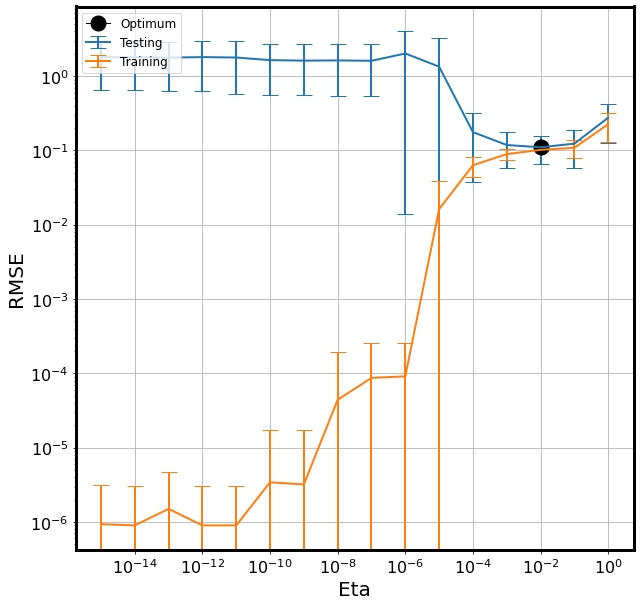

In [13]:
# Options for growth
niter=1                       
mindex_growth =  'nonconservative'

# Determine order of the starting basis
if mindex_growth == None:
    start_ord = nord # if no basis growth, order of the final basis = order of the starting basis
else:
    start_ord = nord-niter+1 # if basis growth, shrink starting basis to allow for growth niter-1 times

# Define PC object    
pc_start = uqtkpce.PCSet("NISPnoq", start_ord, ndim, pc_type, pc_alpha, pc_beta)

# Determine coefficients through BCS
pc_final, c_k = pce_tools.UQTkBCS(pc_start, x_train, y_train, eta, niter, mindex_growth, ntry, eta_folds, eta_growth, eta_plot, regparams, sigma, trval_frac, npccut, pcf_thr, verbose)

# Evaluate the PCE
pce_evals = pce_tools.UQTkEvaluatePCE(pc_final, c_k, x_test)

# Calculate error metric
MSE = np.square(np.subtract(y_test, pce_evals)).mean()
NRMSE=math.sqrt(MSE)/np.abs(y_test.mean())
print("The NRMS error between a", ndim, "-dimensional", model, "function and a BCS-based PC surrogate of \
order", nord, "is")
NRMSE

#### 2 Iterations of Nonconservative Growth

Optimal eta is 1e-05
============  Split # 1 / 3 ============
==== BCS with multiindex of size 35 ====
BCS has selected 15 basis terms out of 35
==== BCS with multiindex of size 49 ====
BCS has selected 21 basis terms out of 49
============  Split # 2 / 3 ============
==== BCS with multiindex of size 35 ====
BCS has selected 23 basis terms out of 35
==== BCS with multiindex of size 61 ====
BCS has selected 20 basis terms out of 61
============  Split # 3 / 3 ============
==== BCS with multiindex of size 35 ====
BCS has selected 17 basis terms out of 35
==== BCS with multiindex of size 58 ====
BCS has selected 20 basis terms out of 58
Coefficients:
[-0.35643911 -0.36400671]
2  terms retained out of a full basis of size 70
The NRMS error between a 4 -dimensional genz_osc function and a BCS-based PC surrogate of order 4 is


1.142293066412162

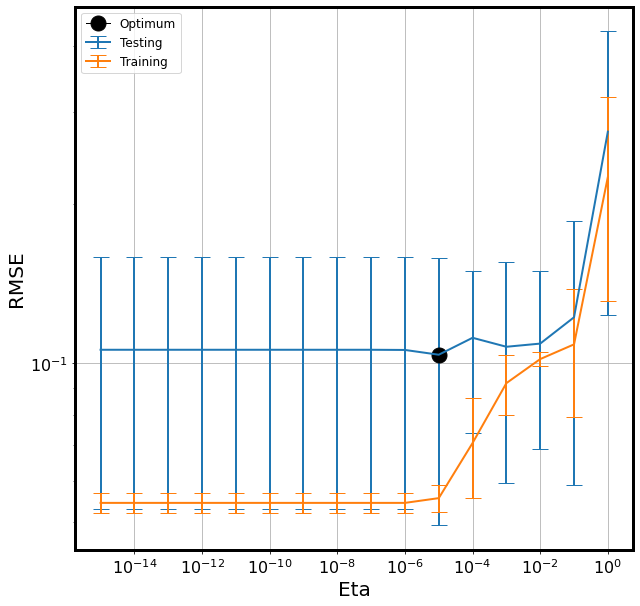

In [14]:
# Options for growth
niter = 2

# Determine order of the starting basis
if mindex_growth == None:
    start_ord = nord # if no basis growth, order of the final basis = order of the starting basis
else:
    start_ord = nord-niter+1 # if basis growth, shrink starting basis to allow for growth niter-1 times

# Define PC Object 
pc_start = uqtkpce.PCSet("NISPnoq", start_ord, ndim, pc_type, pc_alpha, pc_beta)

# Determine coefficients through BCS
pc_final, c_k = pce_tools.UQTkBCS(pc_start, x_train, y_train, eta, niter, mindex_growth, ntry, eta_folds, eta_growth, eta_plot, regparams, sigma, trval_frac, npccut, pcf_thr, verbose)

# Evaluate the PCE
pce_evals = pce_tools.UQTkEvaluatePCE(pc_final, c_k, x_test)

# Calculate error metric
MSE = np.square(np.subtract(y_test, pce_evals)).mean()
NRMSE=math.sqrt(MSE)/np.abs(y_test.mean())
print("The NRMS error between a", ndim, "-dimensional", model, "function and a BCS-based PC surrogate of \
order", nord, "is")
NRMSE

#### 3 Iterations of Nonconservative Growth

Optimal eta is 0.01
============  Split # 1 / 3 ============
==== BCS with multiindex of size 15 ====
BCS has selected 7 basis terms out of 15
==== BCS with multiindex of size 23 ====
BCS has selected 11 basis terms out of 23
==== BCS with multiindex of size 35 ====
BCS has selected 9 basis terms out of 35
============  Split # 2 / 3 ============
==== BCS with multiindex of size 15 ====
BCS has selected 8 basis terms out of 15
==== BCS with multiindex of size 25 ====
BCS has selected 8 basis terms out of 25
==== BCS with multiindex of size 28 ====
BCS has selected 8 basis terms out of 28
============  Split # 3 / 3 ============
==== BCS with multiindex of size 15 ====
BCS has selected 8 basis terms out of 15
==== BCS with multiindex of size 25 ====
BCS has selected 9 basis terms out of 25
==== BCS with multiindex of size 29 ====
BCS has selected 9 basis terms out of 29
Coefficients:
[-0.35541363 -0.36603262 -0.34081526]
3  terms retained out of a full basis of size 70
The NRMS error be

0.9621194510134213

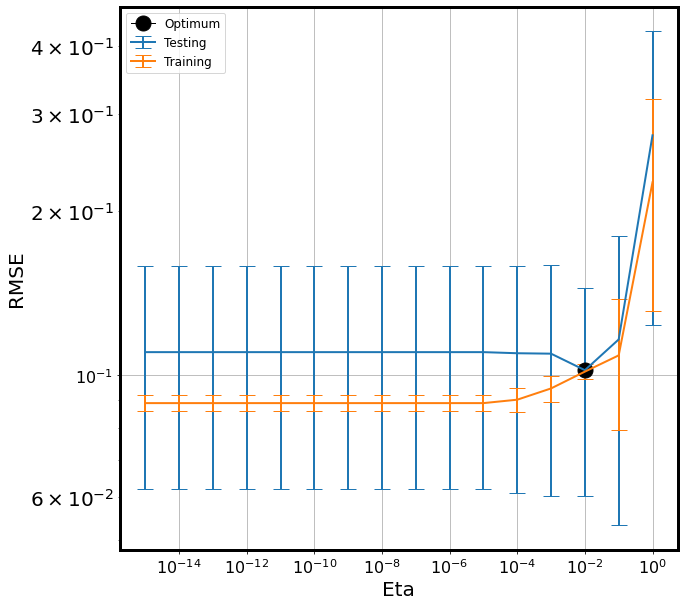

In [15]:
# Options for growth
niter=3

# Determine order of the starting basis
if mindex_growth == None:
    start_ord = nord # if no basis growth, order of the final basis = order of the starting basis
else:
    start_ord = nord-niter+1 # if basis growth, shrink starting basis to allow for growth niter-1 times

# Define PC object
pc_start = uqtkpce.PCSet("NISPnoq", start_ord, ndim, pc_type, pc_alpha, pc_beta)

# Determine coefficients through BCS
pc_final, c_k = pce_tools.UQTkBCS(pc_start, x_train, y_train, eta, niter, mindex_growth, ntry, eta_folds, eta_growth, eta_plot, regparams, sigma, trval_frac, npccut, pcf_thr, verbose)

# Evaluate the PCE
pce_evals = pce_tools.UQTkEvaluatePCE(pc_final, c_k, x_test)

# Calculate error metric
MSE = np.square(np.subtract(y_test, pce_evals)).mean()
NRMSE=math.sqrt(MSE)/np.abs(y_test.mean())
print("The NRMS error between a", ndim, "-dimensional", model, "function and a BCS-based PC surrogate of \
order", nord, "is")
NRMSE